In [16]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import DBSCAN
from model import SimCLRModel
from mlp import MLP
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# Define a function to apply random 2D rotation
def random_2d_rotation(data):
    theta = (torch.rand(data.size(0)) * 2 * np.pi).to(data)
    rotation_matrix = torch.stack([torch.cos(theta), -torch.sin(theta),torch.sin(theta), torch.cos(theta)],dim=1).reshape(data.size(0),2,2).to(data)
    return torch.matmul(rotation_matrix,data.unsqueeze(-1)).squeeze(-1)

def random_translation(data,limits):
    data = (data-limits[0]) / (limits[1]-limits[0]) # normalize to [0,1]
    translation = torch.rand(*data.shape).to(data)
    data = (data + translation) % 1.0 # randomly translate with periodic boundaries
    return limits[0] + (limits[1]-limits[0]) * data # rescale back to original limits


class RingDataset(Dataset):
    def __init__(self,
                 dim: int,
                 radii: list[float],
                 sigmas: float | list[float],
                 num_samples: int,
                 uniform_lims = [0,1],
                 fractions=None,
                 seed=None):
        
        self.rng = np.random.default_rng(seed=seed)
        self.dim = dim
        assert dim >= 2
        self.extra_dims = self.dim - 2
        self.radii = radii
        self.label_values = [i for i in range(len(radii))]
        self.label_map = {i:r for i,r in enumerate(radii)}
        self.sigmas = sigmas
        self.uniform_lims = uniform_lims
        if type(sigmas) == float:
            self.sigmas = [sigmas for _ in range(len(radii))]
        self.fractions = fractions
        if fractions is None:
            self.fractions = [1.0/len(radii) for _ in range(len(radii))]

        self.data, self.labels = self.generate_data(num_samples)
        self.mean = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)

    def generate_data(self,N):
        xdata = []
        ydata = []
        labels = []
        num_per = [int(N*self.fractions[i]) for i in range(len(self.radii))]
        while sum(num_per) > N:
            num_per[-1] -= 1
        for ir,r in enumerate(self.radii):
            theta = self.rng.uniform(low=0.0,high=2*np.pi,size=num_per[ir])
            noise = self.rng.normal(loc=0,scale=self.sigmas[ir],size=num_per[ir])
            x = torch.tensor((r + noise)*np.cos(theta)).unsqueeze(1)
            y = torch.tensor((r + noise)*np.sin(theta)).unsqueeze(1)
            xdata.append(x)
            ydata.append(y)
            labels.append(self.label_values[ir]*torch.ones(num_per[ir]))
        xdata = torch.cat(xdata,dim=0)
        ydata = torch.cat(ydata,dim=0)
        data = torch.cat([xdata,ydata],dim=1)
        labels = torch.cat(labels,dim=0)
        p = torch.randperm(N)
        data = data[p]
        labels = labels[p]

        # add extra dims of random uniform noise
        if self.dim > 2:
            random = self.rng.uniform(low=0,high=1.0,size=(N,self.extra_dims))
            data = torch.cat([data,torch.tensor(random)],dim=1)

        return data,labels
    
    def generate_augmentation(self,batch):
        if batch.size(1) > 2:
            out = batch.clone()
            out[:,2:] = random_translation(out[:,2:],self.uniform_lims)
            return out
        else:
            out = batch.clone()
            out[:,:2] = random_2d_rotation(out[:,:2])
            return out
        
    def normalize(self,batch):
        return (batch - self.mean.to(batch)) / self.std.to(batch)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

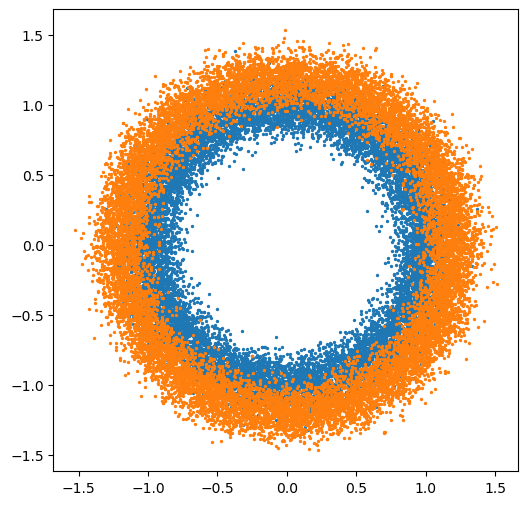

In [61]:
dset = RingDataset(5,[1,1.2],0.1,30000)

data = dset.data
labels = dset.labels

plt.figure(figsize=(6,6))
plt.scatter(data[labels==0,0],data[labels==0,1],s=2)
plt.scatter(data[labels==1,0],data[labels==1,1],s=2)

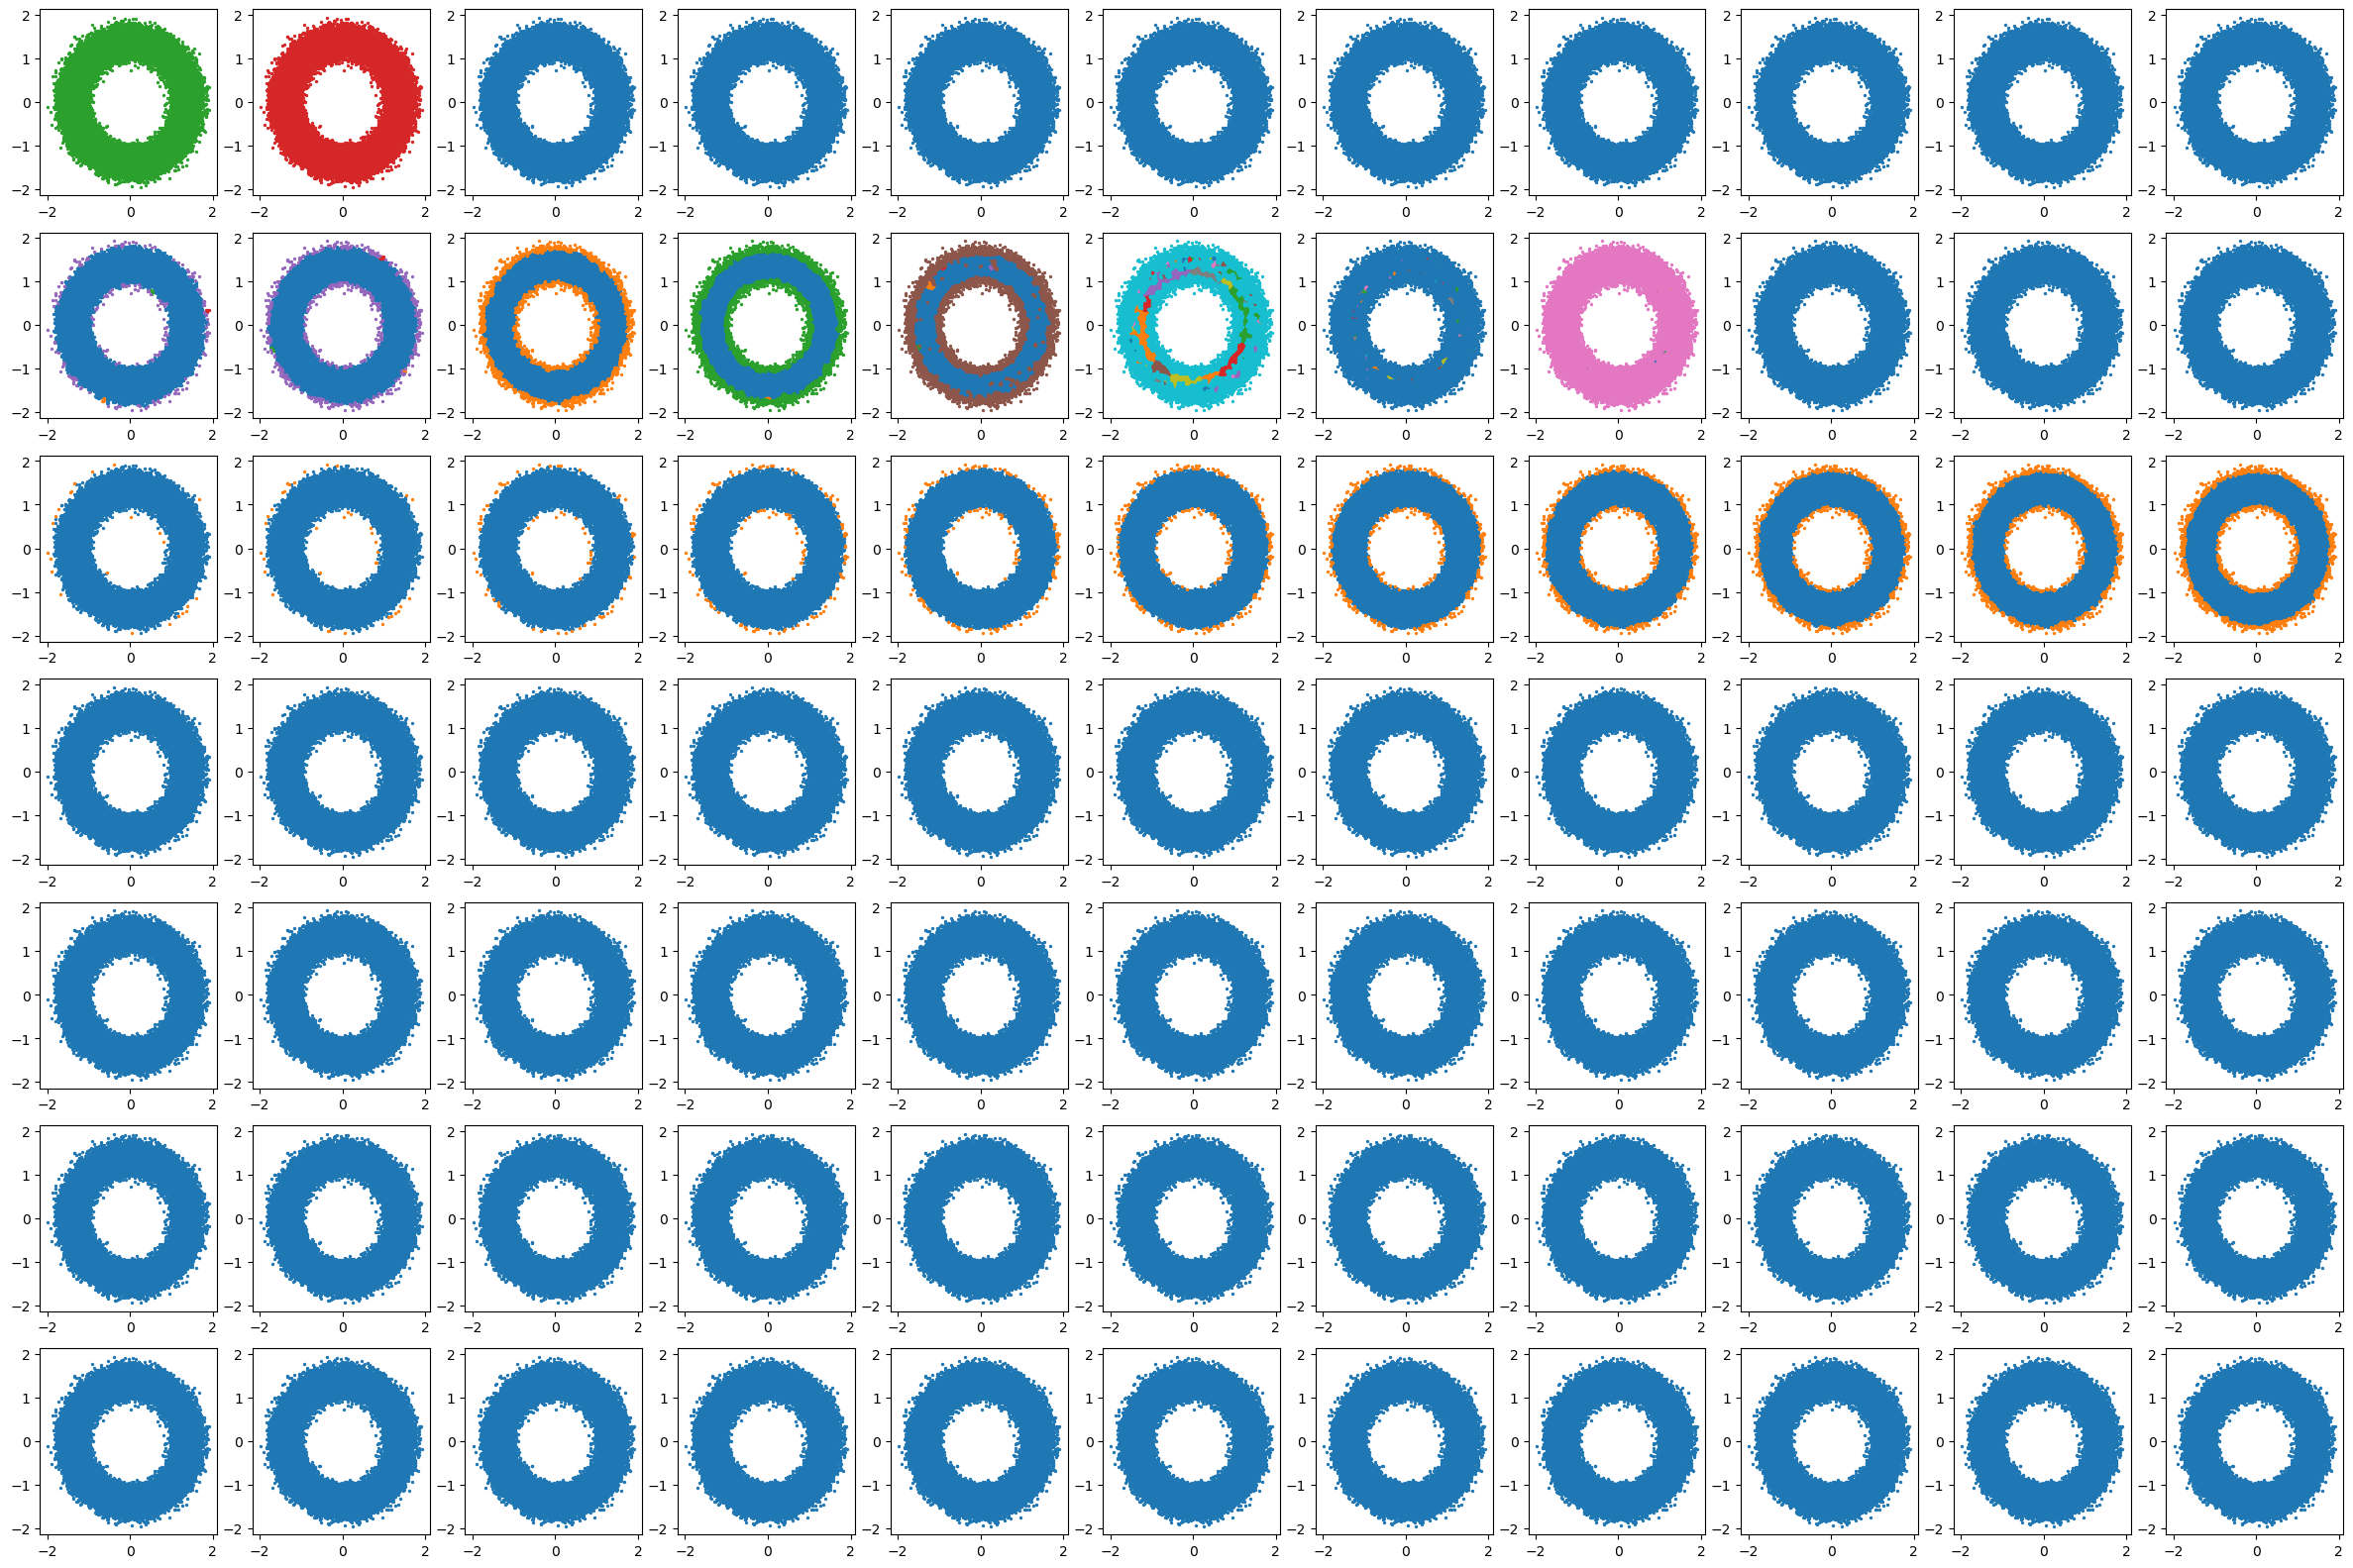

In [4]:
epsilons = [0.01,0.05,0.1,0.25,0.5,0.75,1.0]
samples = [5,10,20,30,40,50,60,70,80,90,100]

fig,axes = plt.subplots(len(epsilons),len(samples),figsize=(30,20))
for i,eps in enumerate(epsilons):
    for j,min_samples in enumerate(samples):
        fit = DBSCAN(eps=eps,min_samples=min_samples).fit(data)
        pred_labels = fit.labels_
        plt.sca(axes[i,j])
        for l in list(set(pred_labels)):
            plt.scatter(data[pred_labels==l,0],data[pred_labels==l,1],s=2)

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


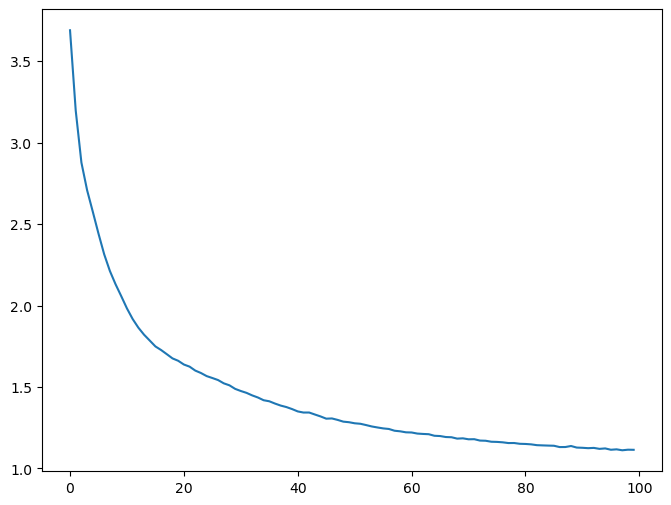

In [97]:
from losses import SupervisedSimCLRLoss
from mlp import MLP
from tqdm import tqdm

temp = 0.05
criterion = SupervisedSimCLRLoss(device=device,temperature=temp)
dim = 10
radii = [1,1.2]
sigma = 0.1
n_train = 50000
dset = RingDataset(dim,radii,sigma,n_train)

# Define the MLP model
embed_dim = 8
embedder = MLP(input_dim=dim, hidden_dims=[128,128,128], output_dim=embed_dim, dropout=0.1).to(device)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
batch_size = 512
dataloader = DataLoader(dset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float().to(device)

        # Apply random 2D rotation
        augmented_data_1 = dset.normalize(dset.generate_augmentation(batch_data))
        augmented_data_2 = dset.normalize(dset.generate_augmentation(batch_data))
        
        # Forward pass
        features_1 = F.normalize(model(augmented_data_1),dim=1).unsqueeze(1)
        features_2 = F.normalize(model(augmented_data_2),dim=1).unsqueeze(1)
        features = torch.cat([features_1, features_2], dim=1)

        #features = model(batch_data).unsqueeze(1)
        
        # Compute SimCLR loss
        loss = criterion(features,labels=None)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

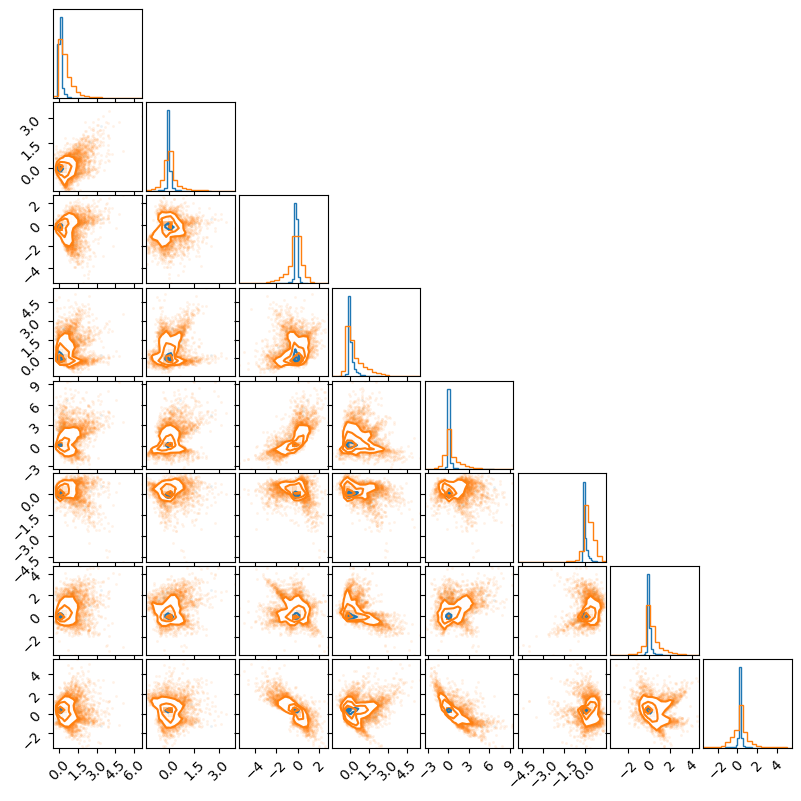

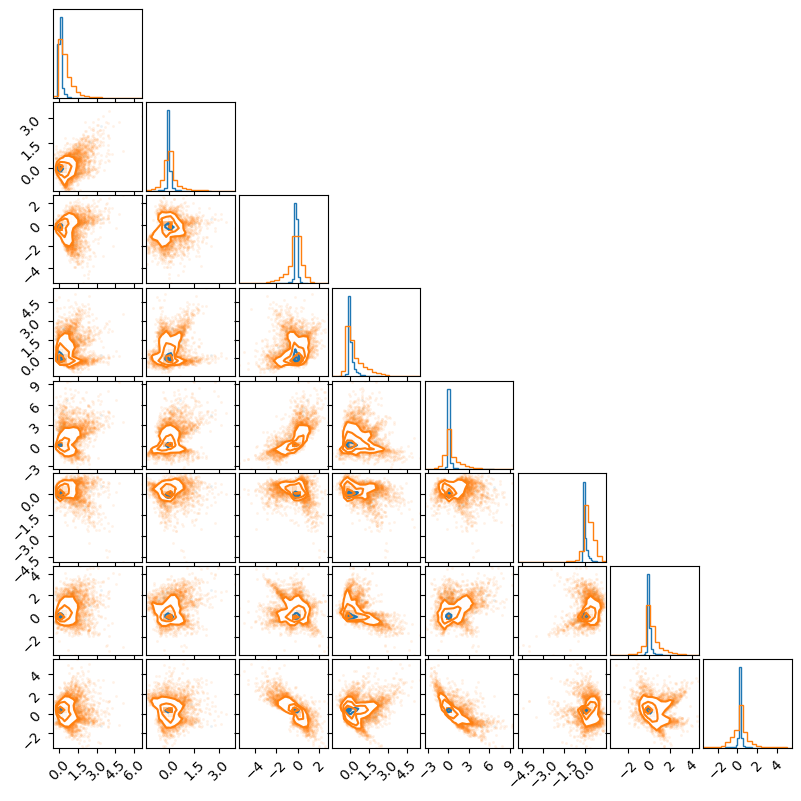

In [98]:
dset = RingDataset(dim,radii,sigma,20000)
data = dset.data.float()
labels = dset.labels.numpy()
with torch.no_grad():
    output = []
    for sp in torch.split(data,10000):
        sp = dset.normalize(sp)
        output.append(model(sp.to(device),embed=True).cpu().numpy())
    output = np.concatenate(output,axis=0)

import corner
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0")
corner.corner(output[labels==1],fig=fig,color="C1")

100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


ROC AUC: 0.91268711


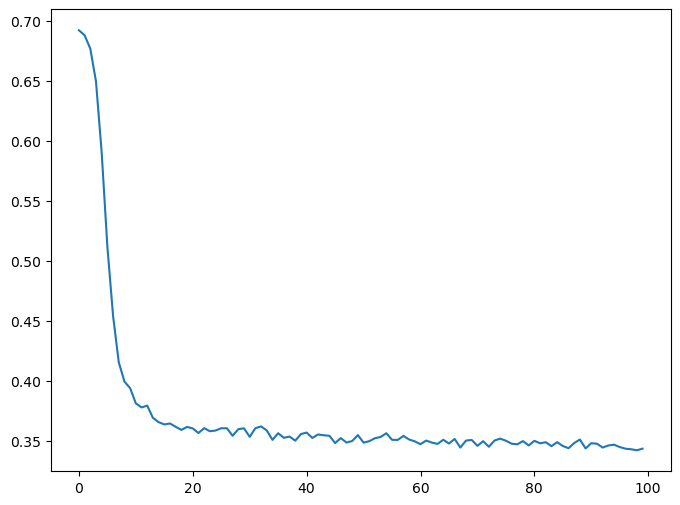

In [99]:
# train an MLP before/after

model_1 = MLP(input_dim=dim,hidden_dims=[32,32,32],output_dim=1,output_activation=nn.Sigmoid).to(device)

optimizer = torch.optim.AdamW(model_1.parameters(), lr=1e-3)
dset_train = RingDataset(dim,radii,sigma,20000)
dset_test = RingDataset(dim,radii,sigma,20000)
dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
criterion = nn.BCELoss()

# training loop
num_epochs = 100
losses = []
for epoch in tqdm(range(num_epochs)):
    model_1.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = dset_train.normalize(batch_data.float().to(device))
        labels = labels.float().unsqueeze(1).to(device)
        output = model_1(batch_data)
        # bce loss
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

# testing evaluation
model_1.eval()
with torch.no_grad():
    output = []
    for sp in torch.split(dset_test.data.float().to(device),10000):
        sp = dset_test.normalize(sp)
        output.append(model_1(sp).cpu().numpy())
    output = np.concatenate(output,axis=0)
    labels = dset_test.labels.numpy()
    # compute ROC AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels,output)
    print(f"ROC AUC: {auc}")

100%|██████████| 150/150 [00:23<00:00,  6.43it/s]


ROC AUC: 0.91592621


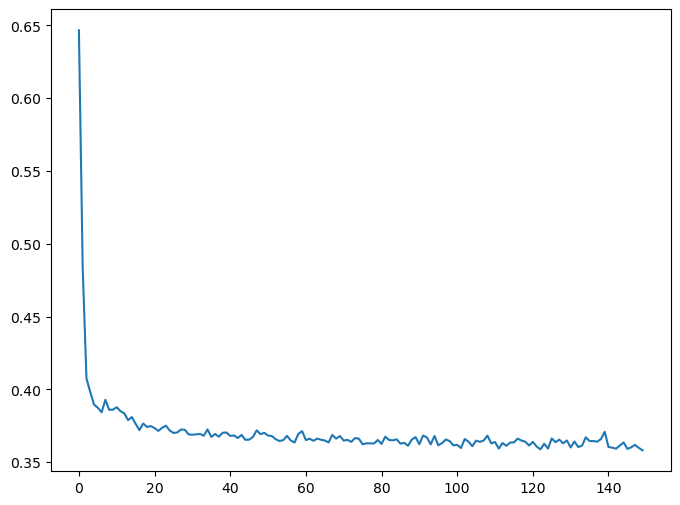

In [100]:
# train an MLP before/after

model_2 = MLP(input_dim=embed_dim,hidden_dims=[32,32,32],output_dim=1,output_activation=nn.Sigmoid).to(device)

optimizer = torch.optim.AdamW(model_2.parameters(), lr=1e-3)
dset_train = RingDataset(dim,radii,sigma,20000)
dset_test = RingDataset(dim,radii,sigma,20000)
new_train_data = []
new_test_data = []
with torch.no_grad():
    for sp in torch.split(dset_train.data,10000):
        sp = dset_train.normalize(sp)
        new_train_data.append(model(sp.float().to(device),embed=True).cpu().numpy())
    for sp in torch.split(dset_test.data,10000):
        sp = dset_test.normalize(sp)
        new_test_data.append(model(sp.float().to(device),embed=True).cpu().numpy())
    new_train_data = np.concatenate(new_train_data,axis=0)
    new_train_data = (new_train_data-new_train_data.mean())/new_train_data.std()
    new_test_data = np.concatenate(new_test_data,axis=0)
    new_test_data = (new_test_data-new_test_data.mean())/new_test_data.std()
dset_train.data = torch.tensor(new_train_data)
dset_test.data = torch.tensor(new_test_data)

dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
criterion = nn.BCELoss()

# training loop
num_epochs = 150
losses = []
for epoch in tqdm(range(num_epochs)):
    model_2.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float().to(device)
        labels = labels.float().unsqueeze(1).to(device)
        output = model_2(batch_data)
        # bce loss
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

# testing evaluation
model_2.eval()
with torch.no_grad():
    output = []
    for sp in torch.split(dset_test.data.float().to(device),10000):
        output.append(model_2(sp).cpu().numpy())
    output = np.concatenate(output,axis=0)
    labels = dset_test.labels.numpy()
    # compute ROC AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels,output)
    print(f"ROC AUC: {auc}")

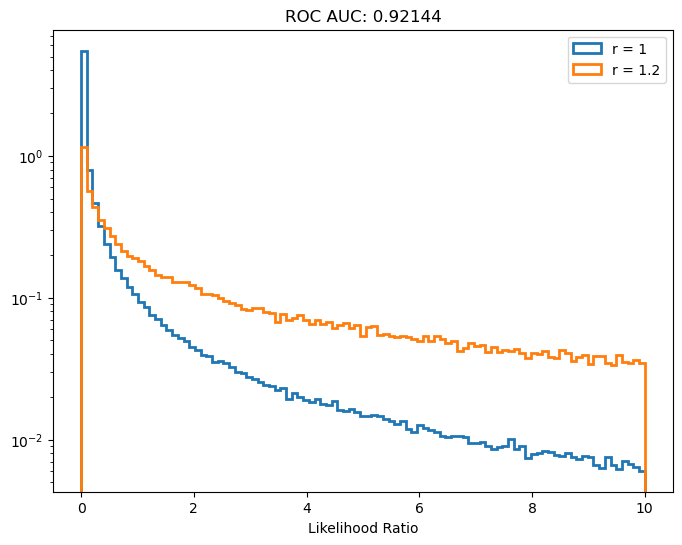

In [102]:
dset_train = RingDataset(dim,radii,sigma,1000000)
r = torch.sum(dset_train.data[:,:2]**2,dim=1).numpy()
labels = dset_train.labels.numpy()

from scipy.stats import norm
lr = norm.pdf(r,loc=radii[1],scale=sigma) / norm.pdf(r,loc=radii[0],scale=sigma)

plt.figure(figsize=(8,6))
h=plt.hist(lr[labels==0],bins=np.linspace(0,10,100),histtype='step',density=True,lw=2,label=f"r = {radii[0]}")
h=plt.hist(lr[labels==1],bins=np.linspace(0,10,100),histtype='step',density=True,lw=2,label=f"r = {radii[1]}")
auc = roc_auc_score(labels,lr)
plt.title(f"ROC AUC: {auc:.5f}")
plt.xlabel("Likelihood Ratio")
plt.yscale('log')
plt.legend()

100%|██████████| 150/150 [01:20<00:00,  1.86it/s]


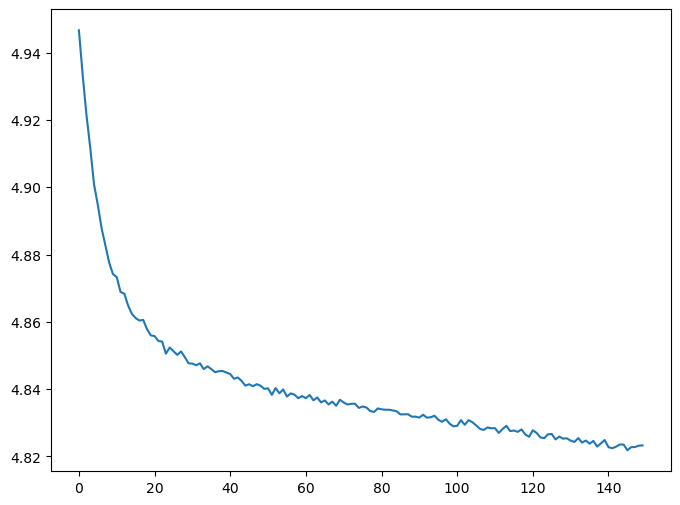

In [112]:
from losses import SupervisedSimCLRLoss
from mlp import MLP
from tqdm import tqdm

temp = 0.05
criterion = SupervisedSimCLRLoss(device=device,temperature=temp)
dim = 10
radii = [1,1.2]
sigma = 0.1
n_train = 50000
dset = RingDataset(dim,radii,sigma,n_train)

# Define the MLP model
embed_dim = 8
embedder = MLP(input_dim=dim, hidden_dims=[128,128,128], output_dim=embed_dim, dropout=0.1).to(device)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 150
batch_size = 1024
dataloader = DataLoader(dset, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float().to(device)
        batch_data = dset.normalize(batch_data)
        embd = F.normalize(model(batch_data),dim=1).unsqueeze(1)
        
        # Compute SimCLR loss
        loss = criterion(embd,labels=labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

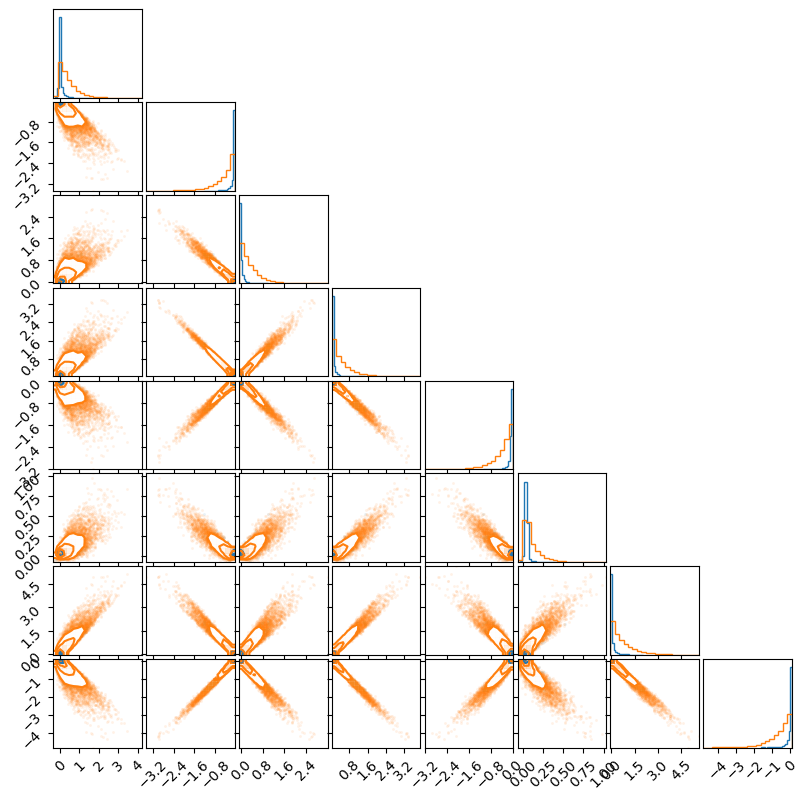

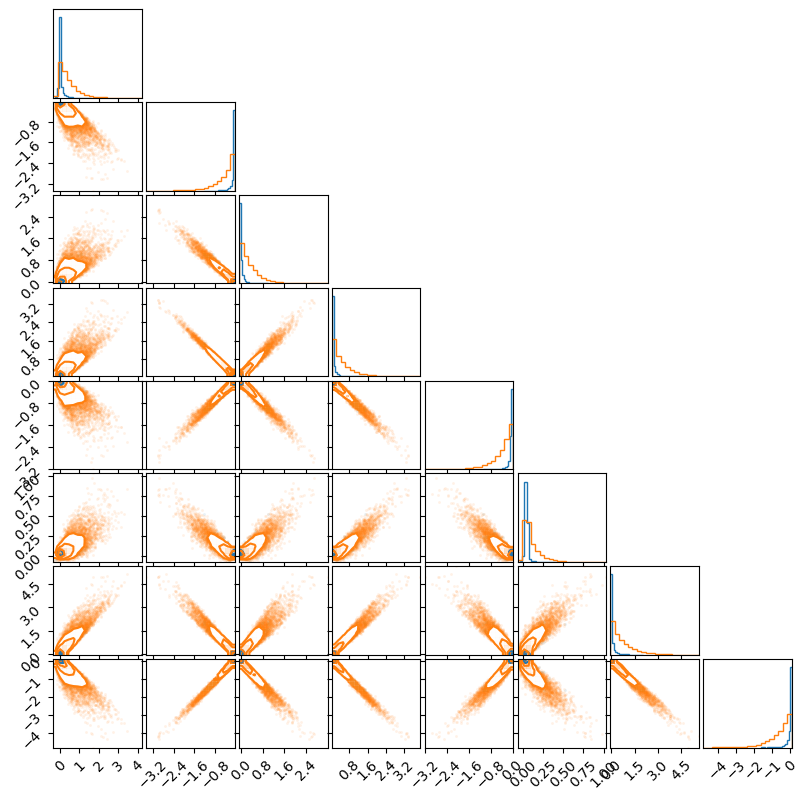

In [113]:
dset = RingDataset(dim,radii,sigma,20000)
data = dset.data.float()
labels = dset.labels.numpy()
with torch.no_grad():
    output = []
    for sp in torch.split(data,10000):
        sp = dset.normalize(sp)
        output.append(model(sp.to(device),embed=True).cpu().numpy())
    output = np.concatenate(output,axis=0)

import corner
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0],fig=fig,color="C0")
corner.corner(output[labels==1],fig=fig,color="C1")

100%|██████████| 150/150 [00:15<00:00,  9.43it/s]

ROC AUC: 0.9034529


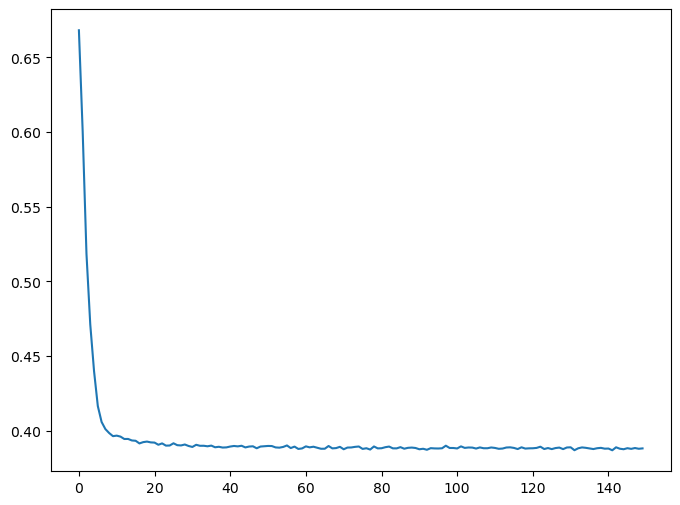

In [114]:
# train an MLP before/after

model_2 = MLP(input_dim=embed_dim,hidden_dims=[32,32,32],output_dim=1,output_activation=nn.Sigmoid).to(device)

optimizer = torch.optim.AdamW(model_2.parameters(), lr=1e-3)
dset_train = RingDataset(dim,radii,sigma,20000)
dset_test = RingDataset(dim,radii,sigma,20000)
new_train_data = []
new_test_data = []
with torch.no_grad():
    for sp in torch.split(dset_train.data,10000):
        sp = dset_train.normalize(sp)
        new_train_data.append(model(sp.float().to(device),embed=True).cpu().numpy())
    for sp in torch.split(dset_test.data,10000):
        sp = dset_test.normalize(sp)
        new_test_data.append(model(sp.float().to(device),embed=True).cpu().numpy())
    new_train_data = np.concatenate(new_train_data,axis=0)
    new_train_data = (new_train_data-new_train_data.mean())/new_train_data.std()
    new_test_data = np.concatenate(new_test_data,axis=0)
    new_test_data = (new_test_data-new_test_data.mean())/new_test_data.std()
dset_train.data = torch.tensor(new_train_data)
dset_test.data = torch.tensor(new_test_data)

dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
criterion = nn.BCELoss()

# training loop
num_epochs = 150
losses = []
for epoch in tqdm(range(num_epochs)):
    model_2.train()
    epoch_loss = []
    for batch_data, labels in dataloader:
        batch_data = batch_data.float().to(device)
        labels = labels.float().unsqueeze(1).to(device)
        output = model_2(batch_data)
        # bce loss
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

# testing evaluation
model_2.eval()
with torch.no_grad():
    output = []
    for sp in torch.split(dset_test.data.float().to(device),10000):
        output.append(model_2(sp).cpu().numpy())
    output = np.concatenate(output,axis=0)
    labels = dset_test.labels.numpy()
    # compute ROC AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels,output)
    print(f"ROC AUC: {auc}")